In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data_censored.csv")

# Display the first few rows
df.head()



,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


In [5]:
# Check basic info
df.info()

# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB


id           0
period       0
treatment    0
x1           0
x2           0
x3           0
x4           0
age          0
age_s        0
outcome      0
censored     0
eligible     0
dtype: int64

In [6]:
df.describe()


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
count,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.000000,725.00000,725.000000
mean,49.278621,7.051034,0.467586,0.405517,-0.173552,0.486897,-0.274722,48.093793,1.091149,0.015172,0.08000,0.234483
std,28.119313,5.802351,0.499293,0.491331,0.997552,0.500173,1.008643,11.834472,0.986206,0.122323,0.27148,0.423968
min,1.000000,0.000000,0.000000,0.000000,-3.284355,0.000000,-3.003087,19.000000,-1.333333,0.000000,0.00000,0.000000
25%,23.000000,2.000000,0.000000,0.000000,-0.809344,0.000000,-0.861899,40.000000,0.416667,0.000000,0.00000,0.000000
50%,50.000000,6.000000,0.000000,0.000000,-0.163060,0.000000,-0.316594,49.000000,1.166667,0.000000,0.00000,0.000000
75%,73.000000,12.000000,1.000000,1.000000,0.494103,1.000000,0.299510,56.000000,1.750000,0.000000,0.00000,0.000000
max,99.000000,19.000000,1.000000,1.000000,3.907648,1.000000,2.048087,78.000000,3.583333,1.000000,1.00000,1.000000


In [7]:
df['treatment'].value_counts()
df['outcome'].value_counts()
df['censored'].value_counts()
df['eligible'].value_counts()


eligible
0    555
1    170
Name: count, dtype: int64

In [10]:
df = df[['id', 'period', 'treatment', 'outcome', 'eligible', 'censored', 'age', 'x1', 'x2', 'x3', 'x4']]

# Convert categorical variables (if needed)
df['treatment'] = df['treatment'].astype(int)
df['eligible'] = df['eligible'].astype(int)

# Display the updated dataset
df.head()


,id,period,treatment,outcome,eligible,censored,age,x1,x2,x3,x4
0,1,0,1,0,1,0,36,1,1.146148,0,0.734203
1,1,1,1,0,0,0,37,1,0.002200,0,0.734203
2,1,2,1,0,0,0,38,0,-0.481762,0,0.734203
3,1,3,1,0,0,0,39,0,0.007872,0,0.734203
4,1,4,1,0,0,0,40,1,0.216054,0,0.734203


In [13]:
import statsmodels.api as sm

# Define independent variables (X) and dependent variable (y)
X = df[['x2', 'x1']]  # Predictors (Denominator Model)
X = sm.add_constant(X)  # Add intercept
y = df['censored']  # Censoring outcome

# Fit logistic regression model
ipcw_model = sm.Logit(y, X).fit()

# Display model summary
print(ipcw_model.summary())


Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04069
Time:                        14:18:47   Log-Likelihood:                -193.88
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                 0.0002679
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2059      0.165    -13.339      0.000      -2.530      -1.882
x2             0.4706      0.

In [14]:
import numpy as np

# Get predicted probabilities
df['censor_prob'] = ipcw_model.predict(X)

# Compute IPCW weights: w = 1 / (1 - P(censored))
df['ipcw_weight'] = 1 / (1 - df['censor_prob'])

# Prevent extreme values (Winsorization)
df['ipcw_weight'] = np.clip(df['ipcw_weight'], 0, df['ipcw_weight'].quantile(0.99))

# Display results
df[['censored', 'censor_prob', 'ipcw_weight']].head()


,censored,censor_prob,ipcw_weight
0,0,0.085615,1.093631
1,0,0.051819,1.054651
2,0,0.080719,1.087807
3,0,0.099556,1.110563
4,0,0.056993,1.060438


In [15]:
# Expand trials dataset by creating a new row for each period of observation
expanded_df = df.copy()

# Create a 'trial_period' column to mimic the expansion process
expanded_df['trial_period'] = expanded_df.groupby('id').cumcount()

# Sort the dataset for better readability
expanded_df = expanded_df.sort_values(by=['id', 'trial_period'])

# Display the expanded dataset
expanded_df.head(10)


,id,period,treatment,outcome,eligible,censored,age,x1,x2,x3,x4,censor_prob,ipcw_weight,trial_period
0,1,0,1,0,1,0,36,1,1.146148,0,0.734203,0.085615,1.093631,0
1,1,1,1,0,0,0,37,1,0.002200,0,0.734203,0.051819,1.054651,1
2,1,2,1,0,0,0,38,0,-0.481762,0,0.734203,0.080719,1.087807,2
3,1,3,1,0,0,0,39,0,0.007872,0,0.734203,0.099556,1.110563,3
4,1,4,1,0,0,0,40,1,0.216054,0,0.734203,0.056993,1.060438,4
5,1,5,1,0,0,1,41,0,-0.057482,0,0.734203,0.096832,1.107214,5
6,2,0,0,0,1,0,26,1,-0.802142,0,-0.990794,0.036077,1.037428,0
7,2,1,1,0,1,0,27,1,-0.983030,0,-0.990794,0.033231,1.034373,1
8,2,2,1,0,0,0,28,0,0.399388,0,-0.990794,0.117336,1.132934,2
9,2,3,0,0,0,0,29,0,1.835085,0,-0.990794,0.207148,1.261270,3


In [16]:
import statsmodels.api as sm

# Define independent variables (predictors)
X_msm = expanded_df[['treatment', 'x2', 'trial_period']]  # Based on the R model
X_msm = sm.add_constant(X_msm)  # Add intercept

# Define dependent variable (outcome)
y_msm = expanded_df['outcome']

# Use IPCW weights in Weighted Least Squares (WLS)
weights = expanded_df['ipcw_weight']
msm_model = sm.WLS(y_msm, X_msm, weights=weights).fit()

# Display model summary
print(msm_model.summary())


                            WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8847
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.449
Time:                        14:25:23   Log-Likelihood:                 494.85
No. Observations:                 725   AIC:                            -981.7
Df Residuals:                     721   BIC:                            -963.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0255      0.009      2.858   

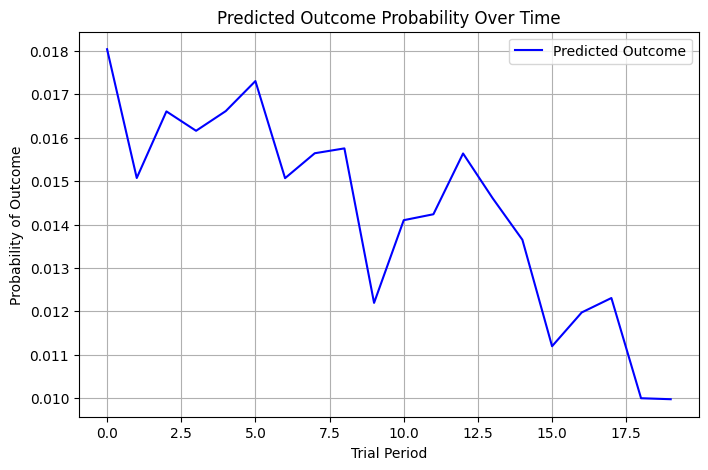

In [17]:
import matplotlib.pyplot as plt

# Generate predicted probabilities
expanded_df['predicted_outcome'] = msm_model.predict(X_msm)

# Aggregate by trial period
survival_df = expanded_df.groupby('trial_period')['predicted_outcome'].mean().reset_index()

# Plot survival probabilities over time
plt.figure(figsize=(8, 5))
plt.plot(survival_df['trial_period'], survival_df['predicted_outcome'], label="Predicted Outcome", color='b')
plt.xlabel("Trial Period")
plt.ylabel("Probability of Outcome")
plt.title("Predicted Outcome Probability Over Time")
plt.legend()
plt.grid()
plt.show()
